Hubbard Model Workflow Example
============================

Prerequisites: OpenFermion, Qiskit, BQSKit, scikit-quant, pyDOE, and SciPy, e.g. install with pip:

`$ python -m pip install qiskit openfermion bqskit scikit-quant pyDOE scikit-learn scipy`

Introduction
--------------

This notebook exercises a couple of different workflow choices to show how alternatives setups and methods fit together. It is by necessity not exhaustive and since it runs on a small example (in the interest of time) that easily and quickly runs to completion regardless, the benefits of different choices will not be obvious in the results. (Differences in outcome could also simply be due to noise, thus any true comparison of techniques should  be over an average of several runs.) However, the focus here is on underlying reasons for those choices, the implementation mechanics, and what to look out for, such that the techniques can be applied to different optimization problems where there would be a benefit.

In a real experiment, there would typically also be a post-processing step to reduce the number of misclassifications.$^1$ This can, however, be simulated by reducing the measurement error (`p_meas`, below). For larger experiments, since the Variational Quantum Eigensolver (VQE) algorithm scales rather badly, it is also worthwhile to look into techniques to reduce the total number of component measurements required.$^2$

First a recap of some of the available choices that we covered in the notebook so far.

**1. Is a good initial available?** If yes, go to 2. If not, then some sort of global search needs to happen (which can be very costly). Most global searches consist of some form of random sampling and need guidance or at least boundaries delimiting the search space. If local minima are expected, a multistart$^3$ method should be used: starting a "global" search in several, judiciously chosen, locations on the optimization surface. The global search need not converge or find the global minimum: it just needs to get close enough to provide a good initial. Having determined this initial, good, or at least tighter, bounds can be set on a region around it.
<br>**2. Are good bounds available?** Bounds are useful to reduce the overall search space; some optimizers (e.g. if stencil-based) even need them or they won't run or will scale so badly to be unusable. Other optimizers, e.g. trust region methods, are naturally limited in their search extent and may never reach the bounds if the initial is good and a large distance away. Bounds can even be harmful, e.g. a gradient-based method may benefit from following the gradient across a boundary, assuming parameters outside the bounds are still computationally (if not physically) valid: temporarily crossing the boundary may bring them back into the search space to a global minimum that is not otherwise reachable when starting descend from the initial. In short, the availability of good bounds is an input into the decision of which optimizer to choose, and conversely, if an optimizer is already settled upon, the bounds may need to be updated. Go to 3.
<br>**3. What does the noise look like?** Noise deforms the optimization surface (this is a separate question from the one of __[how noise affects VQE](hubbard_vqe_noise.ipynb)__), creating local minima and setting up fake gradients. The magnitude and frequency, and whether noise is correlated or stochastic, all drive the decision of which optimizer to use, but also what convergence criteria to pick. If nothing is known a priori, then two generalities can still be observed:
   * Initially, further away from the minimum, gradients are steeper and the impact of noise will be less, even if large and of high frequency.
   * Closer to the minimum, the optimization surface flattens, and the impact of noise will be worse, even if small and of low frequency.

Closer to the minimum, smoothing out the noise becomes more important. Either do this explicitly in the evaluation (i.e. independent of the optimizer), implicitly by e.g. using Gaussian Process models, or by choosing an optimizer that uses local models.
<br>**4. What other resources are available?** If sufficient CPU time is available during the classical step, a tool such as __[BQSKit](https://bqskit.lbl.gov/)__ can be used to produce optimized (shortened) circuits. BQSKit has different methods and settings for all CPU/time budgets and running a single iteration may already be worth it.

**Exercise:** in the workflow below, at each step, consider whether you agree with the setup choices (chosen method, number of Trotter steps, use of BQSKit, max number of evaluations, etc.). Modify as you see fit.

Let's get started. First, create once more a __[Hubbard Model](hubbard_model_intro.ipynb)__ setup.

In [1]:
import hubbard as hb
import logging
import noise_model as noise
import numpy as np
import opti_by_gp as obg

logging.getLogger('hubbard').setLevel(logging.INFO)

In [2]:
# Select a model appropriate for the machine used:
#    laptop -> use small model
#    server -> use medium model

MODEL = hb.small_model
#MODEL = hb.medium_model

# Hubbard model for fermions (Fermi-Hubbard) required parameters
xdim, ydim, t, U, chem, magf, periodic, spinless = MODEL()

# Number of electrons to add to the system
n_electrons_up   = 1
n_electrons_down = 1
n_electrons = n_electrons_up + n_electrons_down

# Total number of "sites", with each qubit representing occupied or not
spinfactor = spinless and 1 or 2
n_qubits = n_sites = xdim * ydim * spinfactor

# Create the Hubbard Model for use with Qiskit
hubbard_op = hb.hamiltonian_qiskit(
    x_dimension        = xdim,
    y_dimension        = ydim,
    tunneling          = t,
    coulomb            = U,
    chemical_potential = chem,
    magnetic_field     = magf,
    periodic           = periodic,
    spinless           = spinless)

To verify our results, it's useful to know the answer (this is often not possible in practice, of course). There are two ways to determine success: whether the ground energy estimate found is close to the exact solution, or whether the optimal parameters found provide an estimate close to the exact solution. Here, we opt for the latter, as it is a more consistent measure. Thus, we need the exact solution and an "exact" object function to use for evaluation of results.

In [16]:
# For record keeping, get the exact energy level
exact = hb.exact(hubbard_op, n_electrons_up, n_electrons_down)

# For verification of results, construct a noise-free, Trotter-free objective
objective_exact = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=-1, noise_model=None, shots=-1, run_bqskit=False)

def res_energy(result):
    try:
        return result.fun
    except AttributeError:
        return result[1]

def res_nevals(result):
    try:
        return result.nfev
    except AttributeError:
        return result[2]

def res_x(result):
    try:
        return result.x
    except AttributeError:
        return result[0]
    
def verify(result):
    print('Energy estimate:', res_energy(result))
    print('Number of evaluations:', res_nevals(result))
    print('Noise-free energy at result:', objective_exact(res_x(result)))

Further ingredients are a couple of optimizers to play with. The ones below are all available through Qiskit, but optimizer interfaces are similar enough to adjust the code below to use your favorite optimizer (e.g. from __[`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html)__).

Create a noise model, the exact (device-specific) details of which will drive most decision making in practice (see the notebook on the __[effects of noise on VQE](hubbard_vqe_noise.ipynb)__). The misclassification (`p_meas`) can realistically be set much lower than typical raw error rates, if you employ effective post-processing techniques.$^1$

In [4]:
# Pull in a couple of optimizers to play with
from qiskit.algorithms.optimizers import COBYLA, SPSA
try:
    from qiskit.algorithms.optimizers import IMFIL, SNOBFIT
except ImportError:
    print("install scikit-quant to use IMFIL and SNOBFIT")

In [5]:
# Construct a noise model; change parameter (or even the whole model: this
# only considers misclassification and depolarization errors) as desired
p_meas = 0.01       # this can be set much lower to "simulate" post-processing
p_gate_1q = 5.E-5
p_gate_2q = 3.E-4

NOISE_MODEL = noise.create(p_gate_1q=p_gate_1q, p_gate_2q=p_gate_2q, p_meas=p_meas)
print(NOISE_MODEL)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz', 'sx', 'cx', 'measure', 'id']
  All-qubits errors: ['id', 'rz', 'sx', 'cx', 'measure']


**Optional Exercise:** we have seen that a minimum of 3 Trotter steps are needed and the default number of shots on IBM devices is 8192 samples. The code below constructs an objective to match and then selects the Qiskit-recommended SPSA optimizer to find the minimum. Note that SPSA will evaluate the objective _at least_ twice per iteration, thus setting `maxiter` to $N$ may actually lead to a multiple of $N$ more evaluations. The point of the exercise is to give a rough idea about the level of difficulty of the chosen models if all defaults are used and no mitigating steps are taken. In particular, the small model should resolve just fine, assuming the number of iterations allowed is commensurate with the noise level, with SPSA only every once in a while getting stuck in a noise-induced local minimum. Experiment with increased shot count and running BQSKit to reduce noise, and how much the problem simplifies with a good initial (set `good=True` in the `MODEL.initial` call below).

In [6]:
# Code is commented out, because it is an optional exercise; this way it does
# not accidentally run if the whole notebook is executed
#"""\
objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=3, noise_model=NOISE_MODEL, shots=8192, run_bqskit=False)

initial_amplitudes, bounds = MODEL.initial(
    n_electrons_up, n_electrons_down, objective.npar(), good=False)

result = SPSA(maxiter=50).minimize(
    objective, initial_amplitudes, bounds=bounds)

verify(result)
#""";

hubbard                |     INFO - objective: 2.59753 @ [ 0.2273956  -0.20611216]
hubbard                |     INFO - objective: 1.38379 @ [-0.1726044   0.19388784]
hubbard                |     INFO - objective: 1.28271 @ [-0.1726044  -0.20611216]
hubbard                |     INFO - objective: 2.23767 @ [0.2273956  0.19388784]
hubbard                |     INFO - objective: 2.23975 @ [0.2273956  0.19388784]
hubbard                |     INFO - objective: 1.28796 @ [-0.1726044  -0.20611216]
hubbard                |     INFO - objective: 1.41296 @ [-0.1726044   0.19388784]
hubbard                |     INFO - objective: 2.63672 @ [ 0.2273956  -0.20611216]
hubbard                |     INFO - objective: 2.21973 @ [0.2273956  0.19388784]
hubbard                |     INFO - objective: 1.27820 @ [-0.1726044  -0.20611216]
hubbard                |     INFO - objective: 1.30371 @ [-0.1726044  -0.20611216]
hubbard                |     INFO - objective: 2.22522 @ [0.2273956  0.19388784]
hubbard     

hubbard                |     INFO - objective: -0.56470 @ [-0.70918993  0.32596684]
hubbard                |     INFO - objective: -0.57214 @ [-1.00593274  0.02922402]
hubbard                |     INFO - objective: -0.58008 @ [-0.71809504  0.31706173]
hubbard                |     INFO - objective: -0.58777 @ [-0.71772678  0.31742998]
hubbard                |     INFO - objective: -0.56311 @ [-1.0044694   0.03068736]
hubbard                |     INFO - objective: -0.80920 @ [-1.00115104  0.31969703]
hubbard                |     INFO - objective: -0.82642 @ [-0.71545973  0.03400572]
hubbard                |     INFO - objective: -0.85400 @ [-0.99873149  0.31727748]
hubbard                |     INFO - objective: -0.81030 @ [-0.71405095  0.03259693]
hubbard                |     INFO - objective: -0.59045 @ [-1.00302033  0.03785887]
hubbard                |     INFO - objective: -0.59216 @ [-0.71931288  0.32156632]
hubbard                |     INFO - objective: -0.59888 @ [-1.00236772  0.03

The first step will have to be a global search and for that reason, ImFil is chosen. The number of Trotter steps is lowered to reduce noise, shots at default, BQSKit can be run if enough classical compute is available, but here it is switched off as far away from the global minimum, the impact of noise is less and ImFil is equipped to handle high noise (alternative `run_bqskit` settings are `True` to run 1 cycle, which will capture most improvement; or `'full'` to run until convergence, if classical resources are not limiting).

With high noise, ImFil is unlikely to use up its full budget: once it gets close to a minimum, the optimization surface flattens and it will not find any gradients on its stencils, which subsequently "fail." This is a useful property, as it leaves more of the budget to the next step, rather than wasting it on chasing fake, noise-induced, gradients.

In [7]:
total_evals = 0

objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=2, noise_model=NOISE_MODEL, shots=8192, run_bqskit=False)

initial_amplitudes, bounds = MODEL.initial(
    n_electrons_up, n_electrons_down, objective.npar(), good=False)

result = IMFIL(maxiter=50).minimize(objective, initial_amplitudes[:], bounds=bounds)

hubbard                |     INFO - objective: 2.06567 @ [ 0.0273956  -0.00611216]
hubbard                |     INFO - objective: 1.77942 @ [0.0273956  0.99388784]
hubbard                |     INFO - objective: -0.55493 @ [-0.9726044  -0.00611216]
hubbard                |     INFO - objective: -0.56030 @ [-1.          0.45581118]
hubbard                |     INFO - objective: 1.93616 @ [0.         0.45581118]
hubbard                |     INFO - objective: 2.07007 @ [-1.         -0.54418882]
hubbard                |     INFO - objective: 0.80310 @ [-0.5         0.45581118]
hubbard                |     INFO - objective: 1.13367 @ [-1.          0.95581118]
hubbard                |     INFO - objective: -0.38330 @ [-1.         -0.04418882]
hubbard                |     INFO - objective: -0.21497 @ [-0.75        0.45581118]
hubbard                |     INFO - objective: 0.29456 @ [-1.          0.70581118]
hubbard                |     INFO - objective: -0.90417 @ [-1.          0.20581118]
hub

In [8]:
# Check the result
verify(result)

# Keep track of the total number of evaluations used
total_evals += res_nevals(result)

Energy estimate: -1.0694580078125
Number of evaluations: 45
hubbard                |     INFO - objective: -1.23590 @ [-0.86487019  0.18634474]
Noise-free energy at result: -1.2359031898420296




After the global search, we can now expect (hope) to be close to the global minimum, which means that the surface flattens and some manner of noise smoothing is required. The number of Trotter steps needs to be increased, as relative differences have more impact close to the minimum. Each extra Trotter step causes an increase in noise (because of an increase in circuit depth), thus, if resources are available, enable BQSkit. (In the interest of time, we run only a single iteration, by setting `run_bqskit=True`.)

Bounds can be tightened. This should be guided by the first of the last failed stencils from ImFil, but the Qiskit optimizer interface makes access to such search details currently not possible. Here, we stick to a guesstimated, but relatively loose, bound. In any case, since ImFil (used under the hood by the Gaussian Process models implementation) always searches the boundaries, if the bounds are too tight, this will show up in the optimal parameters found, as these would be on the boundary. If that happens, go back and loosen the bounds.

[-0.96487019  0.08634474] [-0.76487019  0.28634474]
BQSKit completed in 9.39s
hubbard                |     INFO - objective: -0.98987 @ [-0.8857627  0.1229064]
BQSKit completed in 17.69s
hubbard                |     INFO - objective: -0.94214 @ [-0.962332    0.20471279]
BQSKit completed in 11.84s
hubbard                |     INFO - objective: -0.96021 @ [-0.77099535  0.09357461]
BQSKit completed in 12.61s
hubbard                |     INFO - objective: -0.96802 @ [-0.904572    0.25104478]
BQSKit completed from template in 1.53s
hubbard                |     INFO - objective: -0.89978 @ [-0.84706609  0.28189447]
BQSKit completed in 10.59s
hubbard                |     INFO - objective: -0.98596 @ [-0.80758554  0.15607364]
xnew: [[-0.91184454  0.1494248 ]]
BQSKit completed in 10.62s
hubbard                |     INFO - objective: -0.98413 @ [-0.91184454  0.1494248 ]
energy -0.984130859375
bestX:  [[-0.8857627  0.1229064]]
bestY:  [[-0.98986816]]
Nevals:  7
xnew: [[-0.86029176  0.14996732]]
B

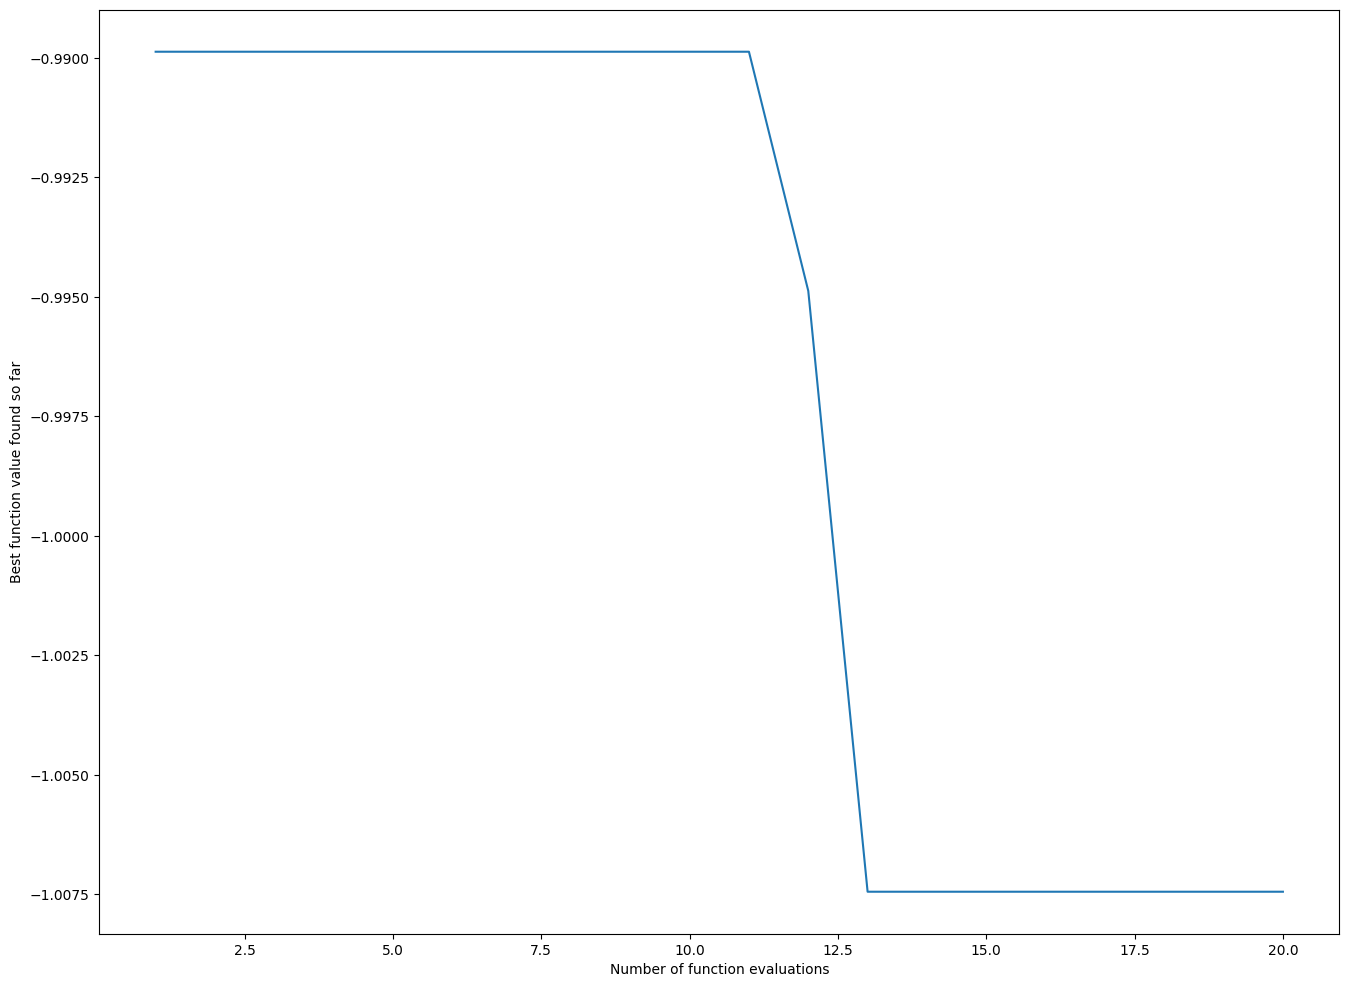

In [14]:
objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=3, noise_model=NOISE_MODEL, shots=8192, run_bqskit=True, save_evals=True)

initial_amplitudes = res_x(result)[:]
bounds = np.zeros((objective.npar(), 2))
bounds[:,0] = np.subtract(initial_amplitudes, 0.1)
bounds[:,1] = np.add(     initial_amplitudes, 0.1)

maxevals = 20

result = obg.opti_by_gp(objective.npar(), bounds, objective, maxevals)

In [17]:
# Check the result
verify(result)

# Keep track of the total number of evaluations used
total_evals += res_nevals(result)

Energy estimate: [-1.00744629]
Number of evaluations: 20
hubbard                |     INFO - objective: -1.21905 @ [-0.83666971  0.13607504]
Noise-free energy at result: -1.219053539856398


Finally, run SnobFit as a last refinement, as its model fits should smooth out the noise effectively and take advantage of the local symmetry (this is not generally applicable, but often the case for physical systems when close to the global minimum, as most things in nature are continuous). To further reduce noise, consider increasing the number of shots (not done here, to keep comparison simpler) and run BQSKit until convergence. Tighten the bounds once more, but be on the lookout for a result at or near the boundary.

In [18]:
objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=3, noise_model=NOISE_MODEL, shots=8192, run_bqskit="full")

initial_amplitudes = res_x(result)[:]
bounds = np.zeros((objective.npar(), 2))
bounds[:,0] = np.subtract(initial_amplitudes, 0.05)
bounds[:,1] = np.add(     initial_amplitudes, 0.05)

result = SNOBFIT(maxiter=30).minimize(objective, initial_amplitudes[:], bounds=bounds)

BQSKit completed in 41.40s
hubbard                |     INFO - objective: -0.91650 @ [-0.83666971  0.05      ]
BQSKit completed in 50.40s
hubbard                |     INFO - objective: -0.98267 @ [-0.787819  0.184854]
BQSKit completed in 57.34s
hubbard                |     INFO - objective: -1.02063 @ [-0.884302  0.145545]
BQSKit completed in 540.08s
hubbard                |     INFO - objective: -0.98340 @ [-0.788195  0.109008]
BQSKit completed in 69.32s
hubbard                |     INFO - objective: -0.94434 @ [-0.885307  0.087217]
BQSKit completed in 36.34s
hubbard                |     INFO - objective: -1.00415 @ [-0.842687  0.180881]
BQSKit completed in 60.46s
hubbard                |     INFO - objective: -0.99902 @ [-0.840112  0.115838]
BQSKit completed in 59.40s
hubbard                |     INFO - objective: -1.00513 @ [-0.809026  0.146583]
BQSKit completed in 41.79s
hubbard                |     INFO - objective: -0.98523 @ [-0.885239  0.184931]
BQSKit completed in 46.09s
hubba

In [19]:
# Check the result
verify(result)

total_evals += res_nevals(result)
print('Total number of evaluations used:', total_evals)
# Keep track of the total number of evaluations used

Energy estimate: -1.0574951171874998
Number of evaluations: 31
hubbard                |     INFO - objective: -1.23125 @ [-0.842259  0.178562]
Noise-free energy at result: -1.231252183603378
Total number of evaluations used: 96


References
-------------

[1] https://arxiv.org/abs/1910.01969, B. Nachman, et al., "Unfolding Quantum Computer Readout Noise"
<br>[2] https://arxiv.org/abs/1907.13623, P. Gokhale, et al., "Minimizing State Preparations in Variational Quantum Eigensolver by Partitioning into Commuting Families"
<br>[3] https://arxiv.org/abs/1905.08768, R. Shaydulin, et al., "Multistart Methods for Quantum Approximate Optimization"